In [2]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import imghdr

In [3]:
print(tf.__version__)

2.8.2


In [4]:
data_dir = "/content/drive/MyDrive/data"

In [5]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [6]:
import numpy as np

In [7]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 161 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
#get data batch
batch = data_iterator.next()

In [10]:
batch[1]   
#1 for SAD
#2 for HAPPY

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0], dtype=int32)

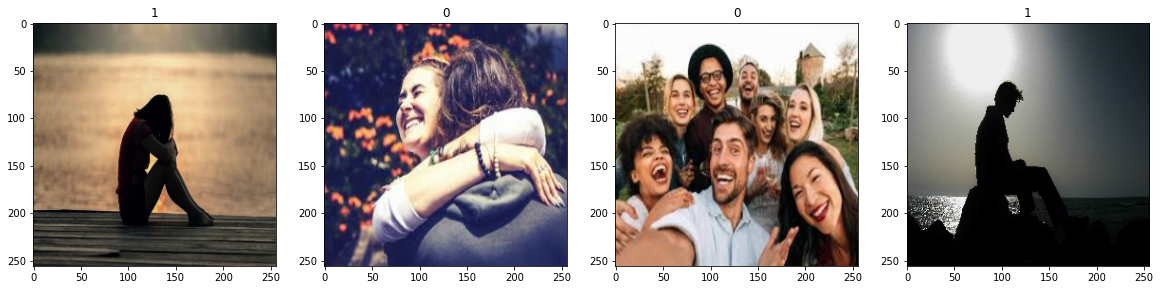

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [12]:
data = data.map(lambda x,y: (x/255, y))

In [13]:
data.as_numpy_iterator().next()[0].max()

1.0

In [14]:
len(data)

6

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [16]:
train_size

4

In [17]:
test_size

1

In [18]:
val_size

1

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 17s 947ms/step - loss: 0.9523 - accuracy: 0.5078 - val_loss: 0.7115 - val_accuracy: 0.3125
Epoch 2/20
4/4 [==============================] - 5s 834ms/step - loss: 0.6663 - accuracy: 0.4844 - val_loss: 0.6512 - val_accuracy: 0.5312
Epoch 3/20
4/4 [==============================] - 5s 910ms/step - loss: 0.5948 - accuracy: 0.6250 - val_loss: 0.5438 - val_accuracy: 0.7500
Epoch 4/20
4/4 [==============================] - 5s 828ms/step - loss: 0.5386 - accuracy: 0.7266 - val_loss: 0.3935 - val_accuracy: 0.8125
Epoch 5/20
4/4 [==============================] - 5s 907ms/step - loss: 0.4733 - accuracy: 0.7734 - val_loss: 0.4722 - val_accuracy: 0.8125
Epoch 6/20
4/4 [==============================] - 5s 909ms/step - loss: 0.4526 - accuracy: 0.7969 - val_loss: 0.3942 - val_accuracy: 0.8125
Epoch 7/20
4/4 [==============================] - 5s 907ms/step - loss: 0.4274 - accuracy: 0.8438 - val_loss: 0.3854 - val_accuracy: 0.9375
Epoch 8/20
4/4 [===

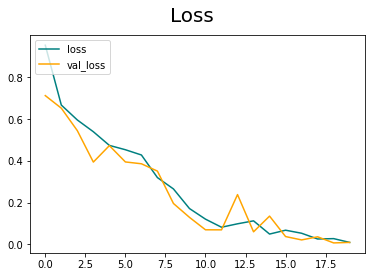

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

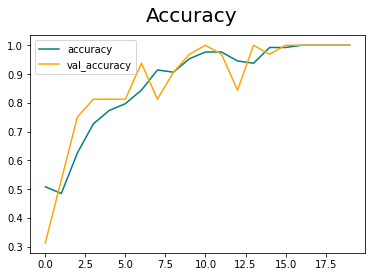

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [30]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [37]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [38]:
import cv2

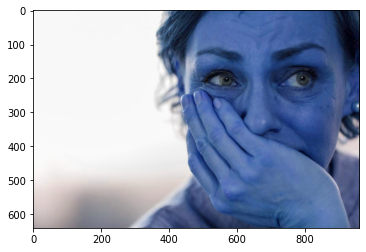

In [44]:
img = cv2.imread('960x0.jpg')
plt.imshow(img)
plt.show()

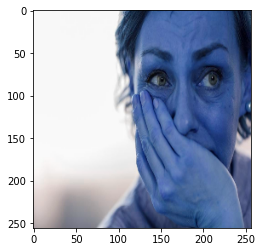

In [48]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [49]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [50]:
yhat

array([[0.9632717]], dtype=float32)

In [51]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


In [52]:
from tensorflow.keras.models import load_model

In [53]:
model.save(os.path.join('models','imageclassifier.h5'))

In [55]:
new_model = load_model('/content/models/imageclassifier.h5')

In [56]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.9632717]], dtype=float32)